## PROJECT CONTEXT
To predict whether a permanent employee is likely to leave so that company could reach out to them beforehand and convince them to stay.


## PROBLEM SPECIFICS

- Deliverable: Executable model script
- Machine Learning Task: Classification
- Target Variable: Status(Employed/Left)
- Win Condition: N/A (best possible model)


In [1]:
import numpy as np

import pandas as pd


from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
df = pd.read_csv('employee_data.csv')

<font size='6' color='red'>EXPLORATORY ANALYSIS</font>

In [3]:
df.shape

(14249, 10)

In [4]:
df = df.drop_duplicates()
df.shape

(14221, 10)

In [5]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [6]:
df.tail()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
14244,178,IT,NaN,0.735865,5,NaN,low,0.263282,Employed,5.0
14245,257,sales,NaN,0.638604,3,NaN,low,0.868209,Employed,2.0
14246,232,finance,1.0,0.847623,5,NaN,medium,0.898917,Left,5.0
14247,130,IT,NaN,0.757184,4,NaN,medium,0.641304,Employed,3.0
14248,159,NaN,NaN,0.578742,3,NaN,medium,0.808850,Employed,3.0


In [7]:
df.dtypes

avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
status                object
tenure               float64
dtype: object

#### Unique Classes of every categorical feature

In [8]:
for cat_features in df.dtypes[df.dtypes==object].index:
    print()
    print(cat_features,'-->',df[cat_features].unique())


department --> ['engineering' 'support' 'sales' 'IT' 'product' 'marketing' 'temp'
 'procurement' 'finance' nan 'management' 'information_technology' 'admin']

salary --> ['low' 'medium' 'high']

status --> ['Left' 'Employed']


#### We are trying to predict for permanent employees hence the temp department is irrelevant. So we will drop observations of temp class.

In [9]:
df = df[df.department!='temp']
df.shape

(14068, 10)

In [10]:
df.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14068.000000,2025.0,12717.000000,14068.000000,300.0,14068.000000,14068.000000
mean,201.083736,1.0,0.718477,3.801038,1.0,0.621295,3.497228
std,49.959962,0.0,0.173062,1.236058,0.0,0.250469,1.460917
min,96.000000,1.0,0.316175,2.000000,1.0,0.040058,2.000000
25%,156.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,200.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


#### Filling the missing values in filed_complaint and recently_promoted

In [11]:
print(df['filed_complaint'].unique())
print(df['recently_promoted'].unique())

[nan  1.]
[nan  1.]


In [12]:
df.filed_complaint.fillna(0,inplace=True)
df.recently_promoted.fillna(0,inplace=True)

In [13]:
print(df['filed_complaint'].unique())
print(df['recently_promoted'].unique())

[0. 1.]
[0. 1.]


#### Removing redundancy by Replacing information_technology and IT as IT because they are same.

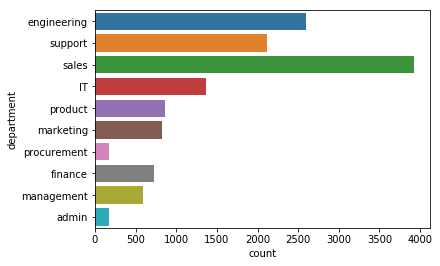

In [14]:
df.department.replace(['information_technology'],'IT',inplace=True)

sns.countplot(y='department',data=df)

#### Fixing Remaining features with missing values

In [15]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

In [16]:
df['department'].fillna('Missing',inplace=True)

#### Making an indicator variable of missingness for last_evaluation feature

In [17]:
df['last_evaluation_missing']=df.last_evaluation.isnull().astype(int)

In [18]:
df.last_evaluation.fillna(0,inplace=True)

In [20]:
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
last_evaluation_missing    0
dtype: int64

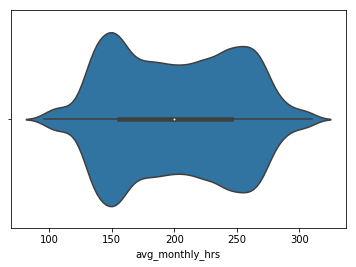

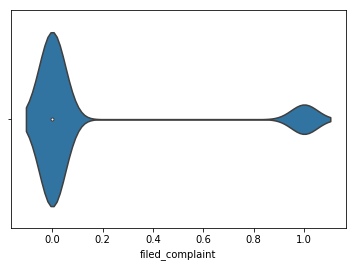

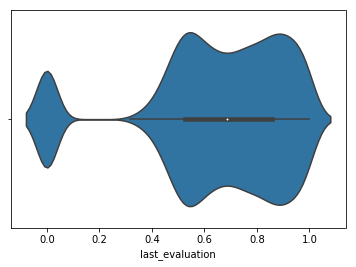

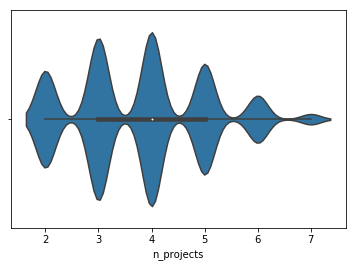

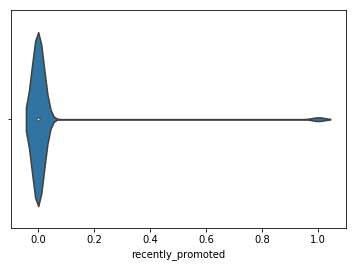

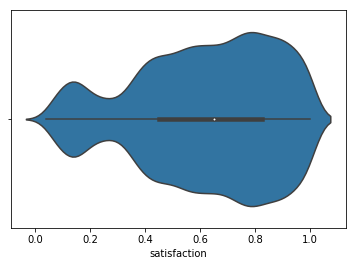

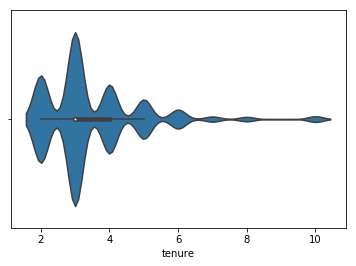

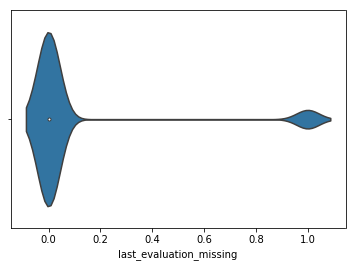

In [21]:
for feature in df.dtypes[df.dtypes!=object].index:
    sns.violinplot(feature,data=df)
    plt.show()

DEDUCED FROM VIOLIN PLOTS - most of features are indicator variables and none of them has any outlier

<font size='6' color='red'>FEATURE ENGINEERING</font>

### Analysing the satifaction and evaluation of employees that have left through seaborn's scatterplot

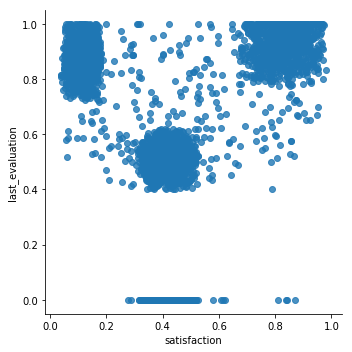

In [23]:
sns.lmplot(x='satisfaction',y='last_evaluation',data= df[df.status=='Left'],fit_reg=False)

#### Inferences from the plot
- there are three clusters which can be engineered to 3 indicator variables
- we will use boolean masks and avoid observations with missing last_evaluation 
- 1) underperformer [last_evaluation < 0.6 & last_evaluation_missing==0]
- 2) unhappy  [satisfaction < 0.2]
- 3) overachiever [last_evaluation > 0.8 & satisfaction > 0.7]

In [24]:
df['underperformer']=((df.last_evaluation<0.6)&(df.last_evaluation_missing==0)).astype(int)
df['unhappy']=(df.satisfaction<0.2).astype(int)
df['overachiever']=((df.last_evaluation>0.8)&(df.satisfaction>0.7).astype(int))

In [25]:
# proportion of each binary feature
df[['underperformer','unhappy','overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64

### Overwriting all the categorical features with indicator dummy variable features
because algorithms can't handle categorical features

In [26]:
df['status'] = pd.get_dummies(df.status).Left

In [27]:
# proportion of observations who have left the company
df.status.mean()

0.23933750355416547

In [28]:
df = pd.get_dummies(df, columns=['department','salary'])

In [29]:
df.head()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,underperformer,...,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,...,0,0,0,0,0,1,0,0,1,0
